# DCGAN

https://arxiv.org/pdf/1511.06434.pdf

### GAN
 - 생성자와 판별자가 경쟁하며 가짜 데이터를 생성하는 네트워크


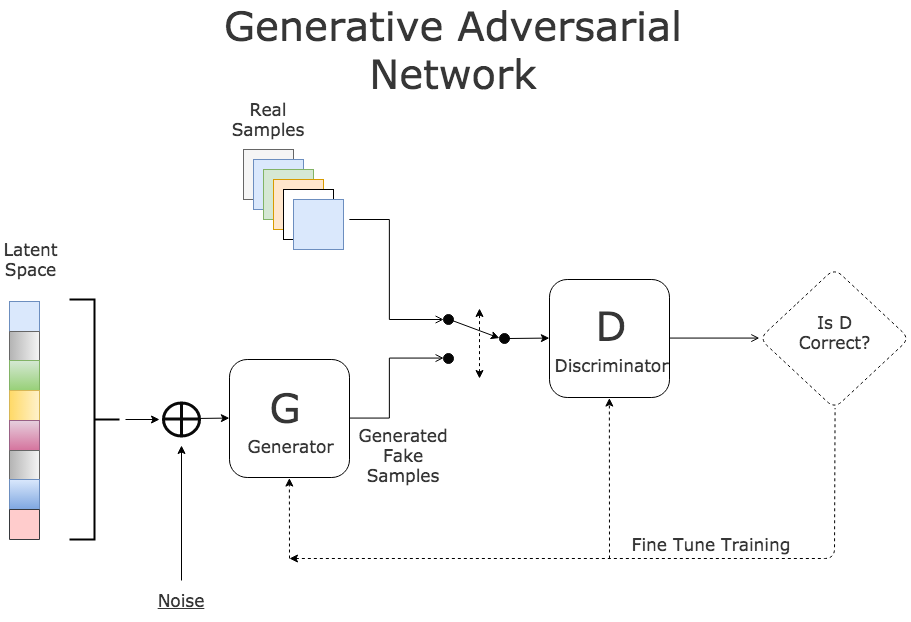

In [2]:
#-*- coding: utf-8 -*-

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

np.random.seed(3)
tf.random.set_seed(3)

## 생성자
- 작은 이미지를 점점 늘려가면서 conv레이어를 통과함
- 7x7 최초이미지 2배씩 증가
- 풀링X
- 패딩: 원본이미지와 입출력 크기를 동일하게 하기 위해 설정(padding='same')
- 활성화함수 tanh: 값을 -1 ~ 1 범위로 출력하므로, 진짜이미지도 -1~1로 출력하도록 수정
- BN: 입력평균 = 0, 분산=1되도록 재배치, 다음층으로 입력될 값을 일정하게 재배치하는 역할



In [5]:
#생성자 모델을 만듭니다.
# 처음에는 7*7 작은거 만든다음에  upsampling으로 키울거기때문에 pooling없이p padding 옵션을 줌
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

## 판별자

* loss: Binary CEE(진짜/가짜 판단),
* optimizer : adam
* stride = 2
    - 가로, 세로 크기가 더 줄어들어 새로운 필터를 적용한 효과가 생김 
    - 드롭아웃이나 풀링처럼 새로운 필터를 적용한 효과가 생김
* discriminator.trainable = False : 판별자는 학습되지 않도록함


In [ ]:
#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

## GAN 모델

In [ ]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


## 신경망 실행

**[참고]**
- model.fit: epochs, batch_size를 넘겨줌
- model.train_on_batch: 데이터를 모두 활용해서 gradient vector를 계산해서 업데이트

11493376/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7053  g_loss:0.6912
epoch:1  d_loss:0.4626  g_loss:0.3284
epoch:2  d_loss:0.5714  g_loss:0.1034
epoch:3  d_loss:0.6590  g_loss:0.0855
epoch:4  d_loss:0.5767  g_loss:0.1680
epoch:5  d_loss:0.5083  g_loss:0.4268
epoch:6  d_loss:0.4874  g_loss:0.7042
epoch:7  d_loss:0.5088  g_loss:0.8769
epoch:8  d_loss:0.4959  g_loss:0.9034
epoch:9  d_loss:0.4859  g_loss:0.8700
epoch:10  d_loss:0.4159  g_loss:0.7858
epoch:11  d_loss:0.4395  g_loss:0.8063
epoch:12  d_loss:0.4903  g_loss:0.8626
epoch:13  d_loss:0.4965  g_loss:0.9031
epoch:14  d_loss:0.5923  g_loss:0.9256
epoch:15  d_loss:0.4899  g_loss:1.0235
epoch:16  d_loss:0.4092  g_loss:1.0004
epoch:17  d_loss:0.6268  g_loss:0.7953
epoch:18  d_loss:0.5560  g_loss:0.6542
epoch:19  d_loss:0.4474  g_loss:0.7110
epoch:20  d_loss:0.4334  g_loss:0.7308
epoch:21  d_loss:0.5035  g_loss:0.7794
epoch:22  d_loss:0.5055  g_loss:0.6619
epoch:23  d_loss:0.4519  g_loss:0.5964
epoch:24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


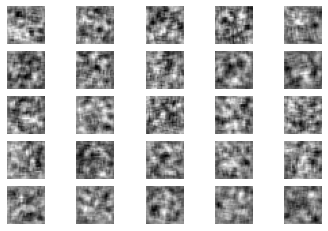

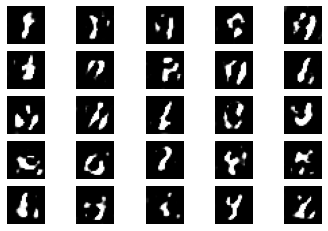

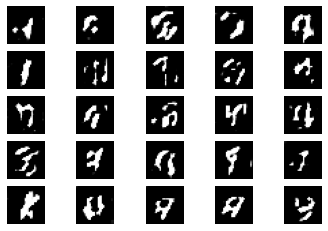

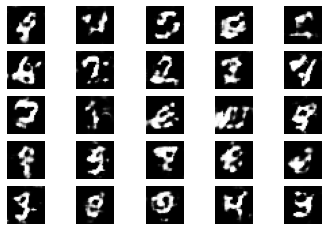

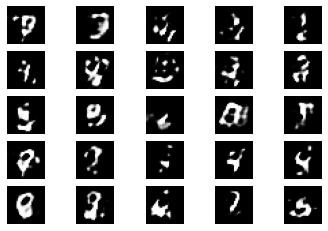

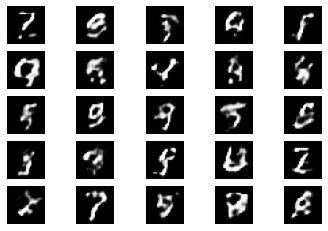

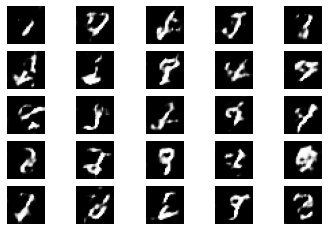

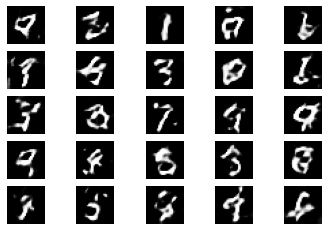

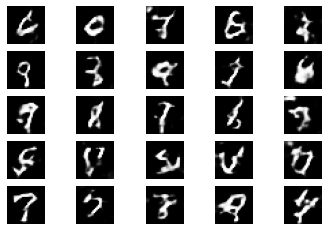

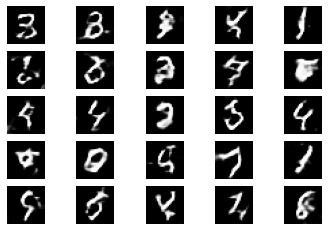

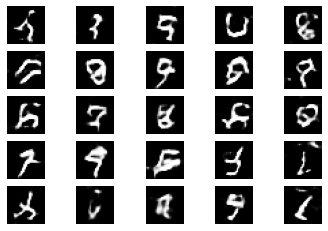

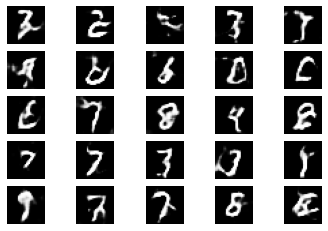

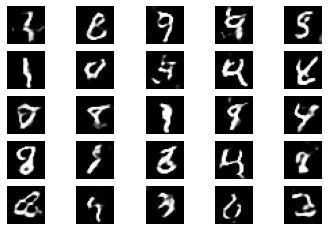

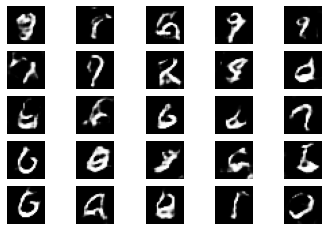

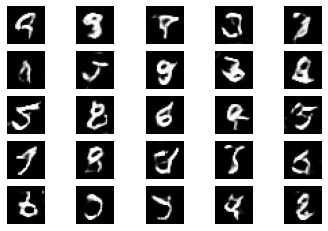

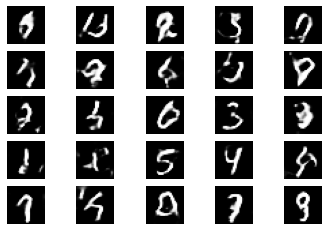

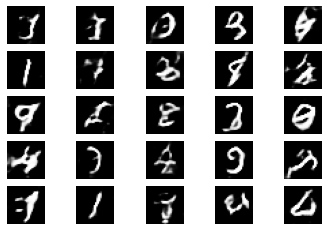

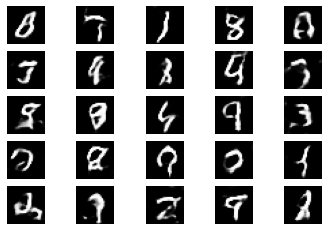

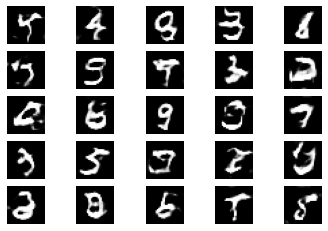

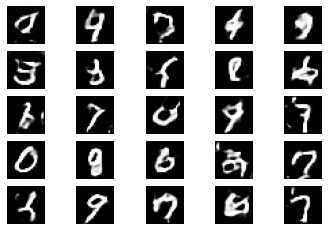

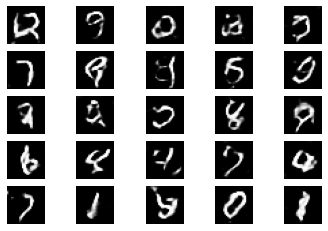

In [ ]:
#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기


  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 
  # 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  (X_train, _), (_, _) = mnist.load_data()  
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  # 픽셀값은 0에서 255사이의 값입니다. 
  # 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 
  # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  X_train = (X_train - 127.5) / 127.5  
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.